# Additional Cleaning and Exploration

### Imports

In [160]:
import pandas as pd
import seaborn as sns
import pandasql as ps
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost

### Source DataFrame
- Read
- Drop some columns

In [161]:
df = pd.read_csv("final_aggregated_df.csv")

In [162]:
df = df.drop(['is_monday','is_tuesday','is_wednesday','is_thursday','is_friday','is_saturday','is_sunday'], axis = 1)

### Check Data

In [163]:
df.shape

(12104, 116)

### Add the Missing Days
- Transform the date to a different format
- Include the missing days

In [164]:
date_dim = ps.sqldf("""
WITH RECURSIVE dates(date) AS (
  VALUES('2012-01-01')
  UNION ALL
  SELECT date(date, '+1 day')
  FROM dates
  WHERE date < '2016-12-31'
)
SELECT date FROM dates
""", locals())

date_dim.head()

date
0  2012-01-01
1  2012-01-02
2  2012-01-03
3  2012-01-04
4  2012-01-05

In [165]:
df = ps.sqldf("""

SELECT
  x.*,
  y.*
FROM
(SELECT
b.sector as sector_, a.date,
CASE WHEN strftime('%w', a.date) = "1" THEN 1 ELSE 0 END AS is_monday,
CASE WHEN strftime('%w', a.date) = "2" THEN 1 ELSE 0 END AS is_tuesday,
CASE WHEN strftime('%w', a.date) = "3" THEN 1 ELSE 0 END AS is_wednesday,
CASE WHEN strftime('%w', a.date) = "4" THEN 1 ELSE 0 END AS is_thursday,
CASE WHEN strftime('%w', a.date) = "5" THEN 1 ELSE 0 END AS is_friday,
CASE WHEN strftime('%w', a.date) = "6" THEN 1 ELSE 0 END AS is_saturday,
CASE WHEN strftime('%w', a.date) = "0" THEN 1 ELSE 0 END AS is_sunday
FROM date_dim a
CROSS JOIN (select 1 AS sector
UNION ALL select 2
UNION ALL select 3
UNION ALL select 4
UNION ALL select 5
UNION ALL select 6
UNION ALL select 7) b

) x
LEFT JOIN
df y on
SUBSTR(collision_date,1,10) = x.date
and y.sector = x.sector_
order by 1,2
""", locals())

In [166]:
df.head()

sector_        date  is_monday  is_tuesday  is_wednesday  is_thursday  \
0        1  2012-01-01          0           0             0            0   
1        1  2012-01-02          1           0             0            0   
2        1  2012-01-03          0           1             0            0   
3        1  2012-01-04          0           0             1            0   
4        1  2012-01-05          0           0             0            1   

   is_friday  is_saturday  is_sunday  Unnamed: 0           ...            \
0          0            0          1         0.0           ...             
1          0            0          0         1.0           ...             
2          0            0          0         2.0           ...             
3          0            0          0         3.0           ...             
4          0            0          0         4.0           ...             

   lighting_B lighting_C  lighting_D  lighting_E  lighting_Unknown  \
0         1.0        1.0         0.0         0.0               0.0   
1         0.0        2.0         1.0         0.0               0.0   
2         1.0        2.0         1.0         0.0               0.0   
3         0.0        2.0         1.0         0.0               0.0   
4         0.0        4.0         0.0         0.0               0.0   

   control_device_A  control_device_B  control_device_C  control_device_D  \
0               1.0               0.0               0.0               3.0   
1               2.0               0.0               0.0               4.0   
2               2.0               0.0               0.0               4.0   
3               1.0               0.0               0.0               4.0   
4               4.0               0.0               0.0               9.0   

   control_device_Unknown  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  

[5 rows x 125 columns]

### Impute and Drop Ends of Dataset

In [167]:
def impute_series(pd_df,target,window=15,min_periods=1,center=True):
    return(pd_df.fillna(pd_df.rolling(window=15,min_periods=1,center=True).mean())[target])

In [168]:
for column in ["collisions", "is_12AM_3AM", "is_3AM_6AM", "is_6AM_9AM", "is_9AM_12PM", "is_12PM_3PM", "is_3PM_6PM", "is_6PM_9PM", "is_9PM_12AM","high_severity", "low_severity", "number_killed", "number_injured", "pedestrian_accident", "bicycle_accident", "motorcycle_accident", "truck_accident", "alcohol_involved", "count_ped_killed", "count_ped_injured", "count_bicyclist_killed", "count_bicyclist_injured", "intersection_N", "intersection_Unknown", "intersection_Y", "location_type_H", "location_type_I", "location_type_N", "location_type_R", "primary_coll_factor_A", "primary_coll_factor_B", "primary_coll_factor_C", "primary_coll_factor_D", "primary_coll_factor_E", "primary_coll_factor_Unknown", "pcf_viol_category_00", "pcf_viol_category_01", "pcf_viol_category_02", "pcf_viol_category_03", "pcf_viol_category_04", "pcf_viol_category_05", "pcf_viol_category_06", "pcf_viol_category_07", "pcf_viol_category_08", "pcf_viol_category_09", "pcf_viol_category_10", "pcf_viol_category_11", "pcf_viol_category_12", "pcf_viol_category_13", "pcf_viol_category_14", "pcf_viol_category_15", "pcf_viol_category_16", "pcf_viol_category_17", "pcf_viol_category_18", "pcf_viol_category_21", "pcf_viol_category_22", "pcf_viol_category_24", "pcf_viol_category_Unknown", "hit_and_run_F", "hit_and_run_M", "hit_and_run_N", "type_of_collision_A", "type_of_collision_B", "type_of_collision_C", "type_of_collision_D", "type_of_collision_E", "type_of_collision_F", "type_of_collision_G", "type_of_collision_H", "type_of_collision_Unknown", "road_surface_A", "road_surface_B", "road_surface_C", "road_surface_D", "road_surface_Unknown", "road_cond_1_A", "road_cond_1_B", "road_cond_1_C", "road_cond_1_D", "road_cond_1_E", "road_cond_1_F", "road_cond_1_G", "road_cond_1_H", "road_cond_1_Unknown", "lighting_A", "lighting_B", "lighting_C", "lighting_D", "lighting_E", "lighting_Unknown", "control_device_A", "control_device_B", "control_device_C", "control_device_D", "control_device_Unknown"]:
    df[column] = df.fillna(0)[column]

    

In [169]:
for column in ["avg_density_per_collision", "avg_wealth_per_collision", "avg_intersections_per_collision", "avg_watts_per_collision", "avg_lightbulbs_per_collision", "avg_one_way_signs_per_collision", "avg_speed_limit_signs_per_collision", "avg_no_u_turn_signs_per_collision", "avg_stop_sign_per_collision", "avg_yield_sign_per_collision", "weather_1_A", "weather_1_B", "weather_1_C", "weather_1_D", "weather_1_E", "weather_1_F", "weather_1_G", "weather_1_Unknown"]:
    df[column] = impute_series(df, target=column)
    

In [170]:
df = ps.sqldf("""select * from df order by date, sector_""")

### Change Point
There is a change point at the end of the dataset as seen by this plot.  Therefore, the last few months of data have been dropped.

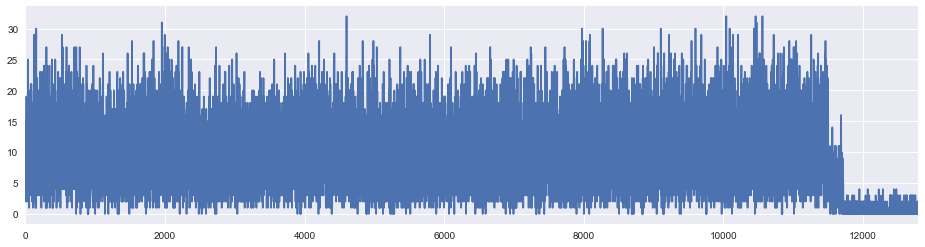

In [171]:
df['collisions'].plot(figsize=(16, 4))

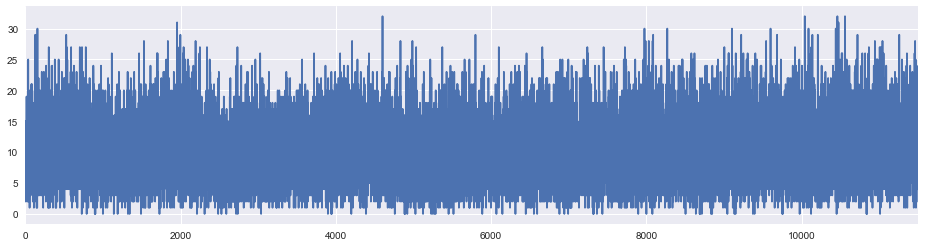

In [172]:
df['collisions'].iloc[0:11501].plot(figsize=(16, 4))

In [173]:
df = df.iloc[0:11501]

In [174]:
# # Two subplots, the axes array is 1-d
# f, axarr = plt.subplots(7, sharex=True)
# axarr[0].plot(x="date", y=ps.sqldf("""SELECT * from df where sector_ = 1""", locals())['collisions'])
# axarr[0].set_title('Sharing X axis')
# axarr[1].plot(x="date", y=ps.sqldf("""SELECT * from df where sector_ = 2""", locals())['collisions'])


plot_df = ps.sqldf("""
SELECT
  date,
  MAX(CASE WHEN sector_ = 1 THEN collisions ELSE 0 END) AS sector1,
  MAX(CASE WHEN sector_ = 2 THEN collisions ELSE 0 END) AS sector2,
  MAX(CASE WHEN sector_ = 3 THEN collisions ELSE 0 END) AS sector3,
  MAX(CASE WHEN sector_ = 4 THEN collisions ELSE 0 END) AS sector4,
  MAX(CASE WHEN sector_ = 5 THEN collisions ELSE 0 END) AS sector5,
  MAX(CASE WHEN sector_ = 6 THEN collisions ELSE 0 END) AS sector6,
  MAX(CASE WHEN sector_ = 7 THEN collisions ELSE 0 END) AS sector7
FROM df
GROUP BY 1
order by 1
""")


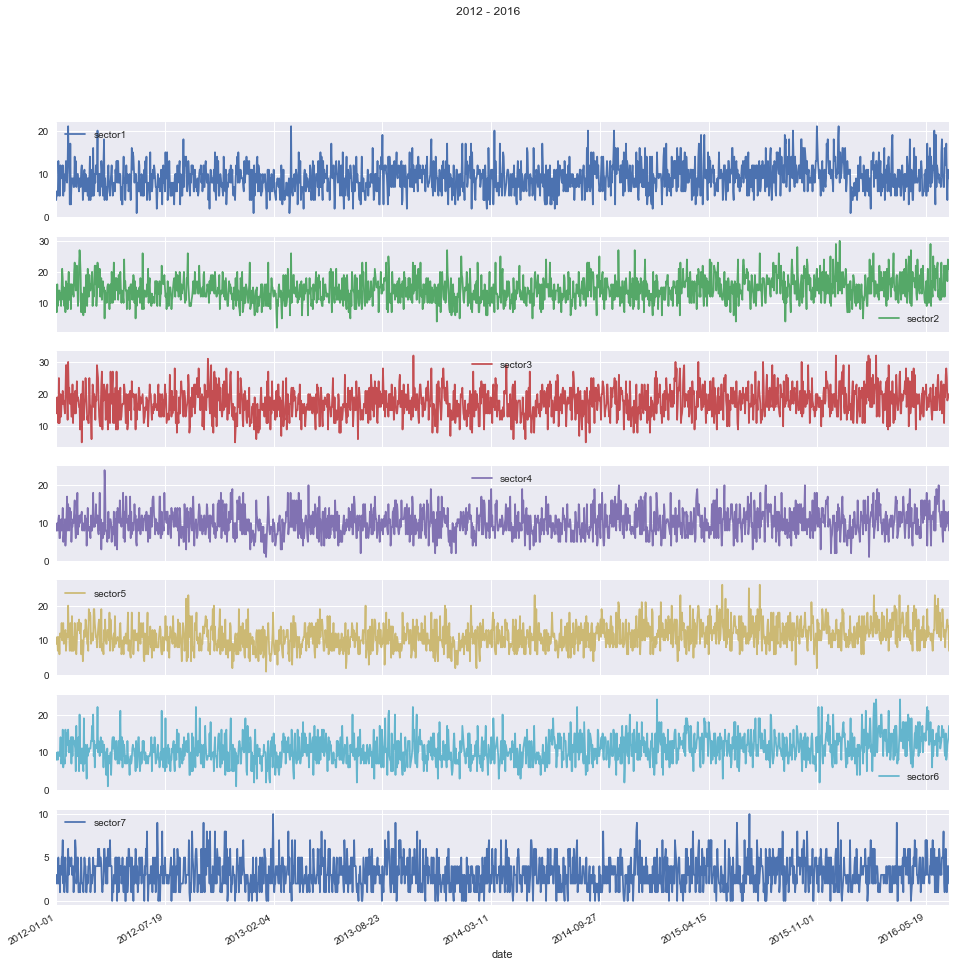

In [175]:
plot_df.plot(x="date", subplots=True, figsize=(16, 16), title="2012 - 2016");

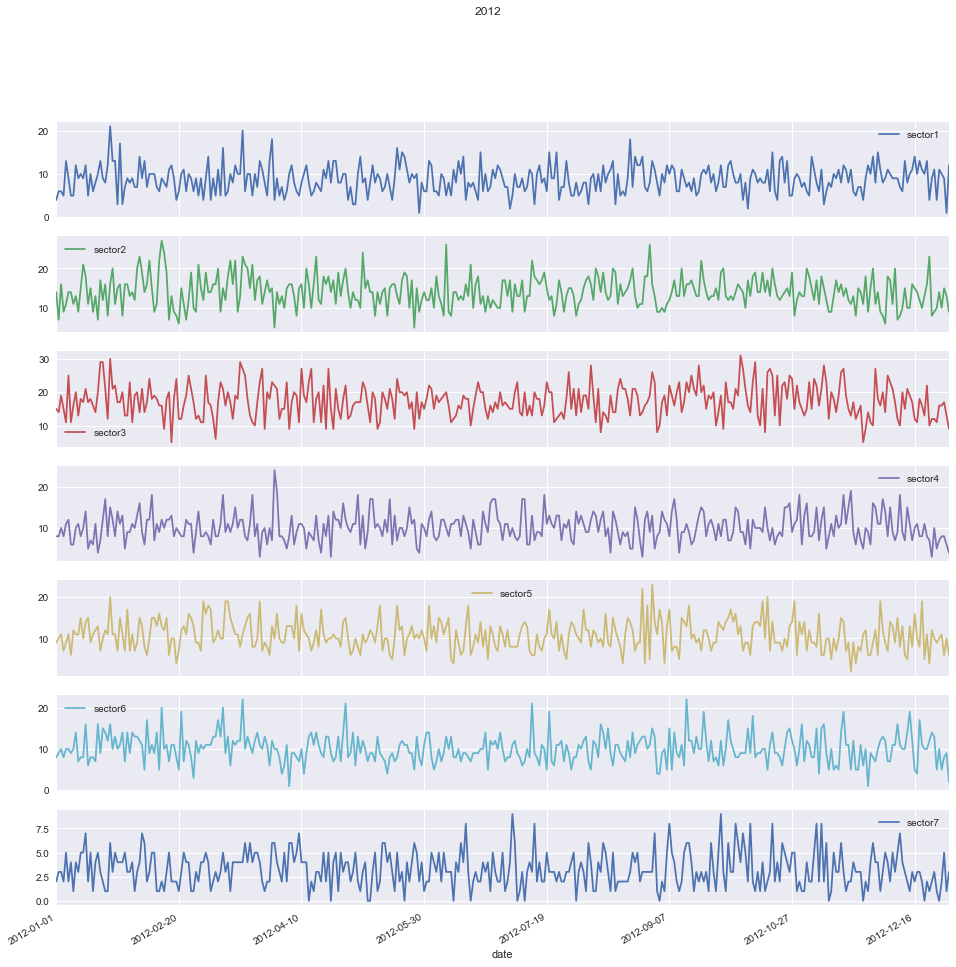

In [176]:
plot_df.iloc[0:365].plot(x="date", subplots=True, figsize=(16, 16), title="2012");

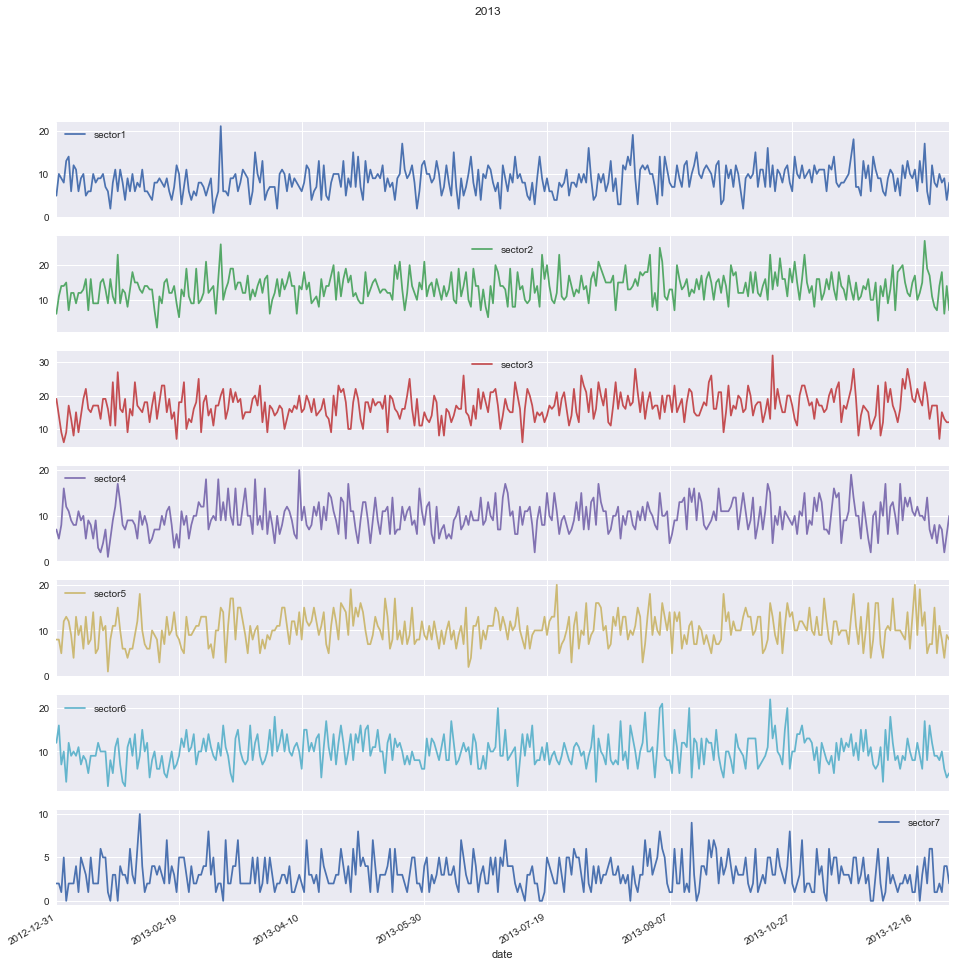

In [177]:
plot_df.iloc[365:730].plot(x="date", subplots=True, figsize=(16, 16), title="2013");

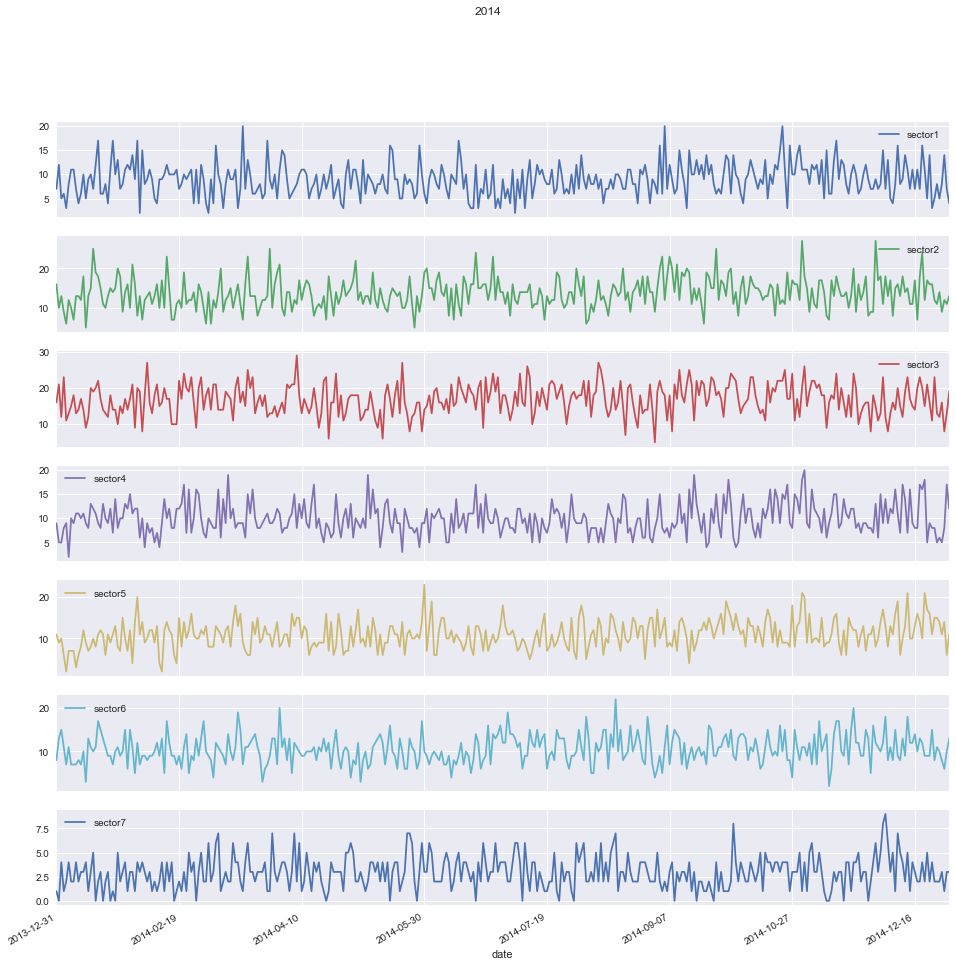

In [178]:
plot_df.iloc[730:1095].plot(x="date", subplots=True, figsize=(16, 16), title="2014");

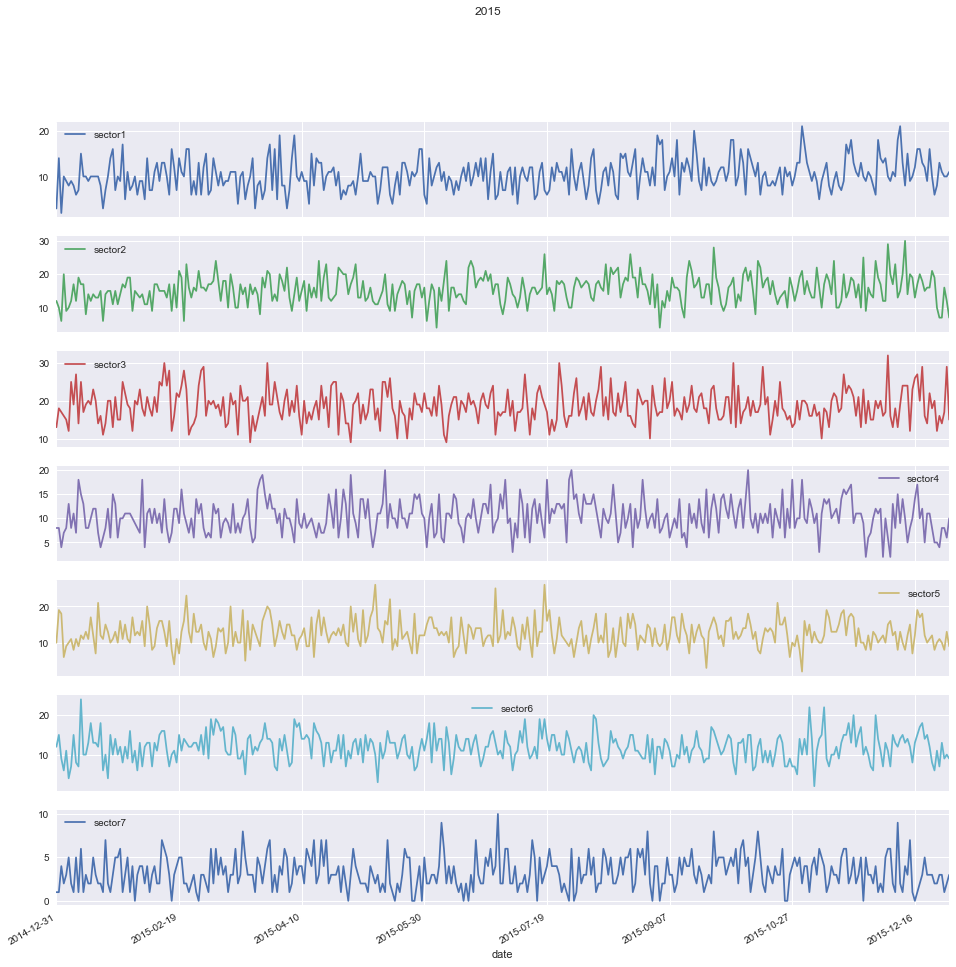

In [179]:
plot_df.iloc[1095:1460].plot(x="date", subplots=True, figsize=(16, 16), title="2015");

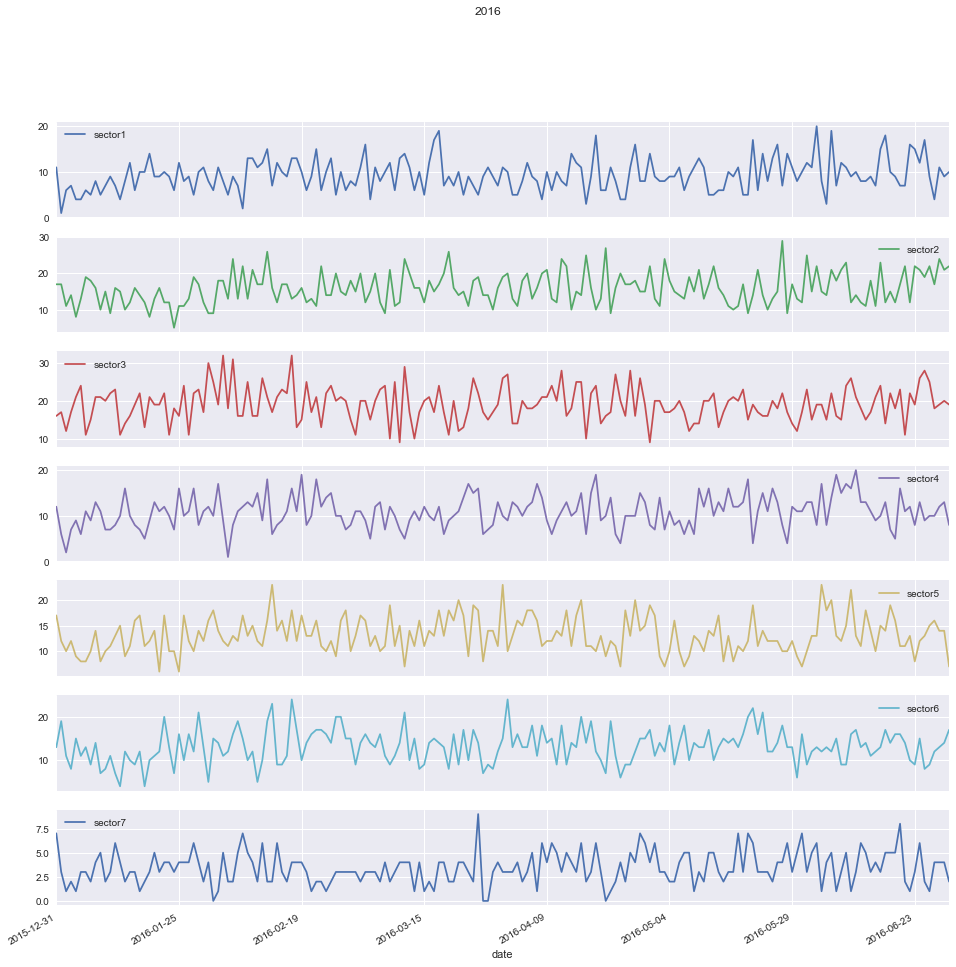

In [180]:
plot_df.iloc[1460:1825].plot(x="date", subplots=True, figsize=(16, 16), title="2016");

### Check Dates
- Check min/max
- Check that the row_count, dates, and diff match by sector

In [181]:
ps.sqldf("""select sector_, count(*) row_count, count(distinct date) dates
,  julianday(max(date)) - julianday(min(date)) + 1 diff, 
 min(date), max(date) 

from df group by 1""", locals())

sector_  row_count  dates    diff   min(date)   max(date)
0        1       1643   1643  1643.0  2012-01-01  2016-06-30
1        2       1643   1643  1643.0  2012-01-01  2016-06-30
2        3       1643   1643  1643.0  2012-01-01  2016-06-30
3        4       1643   1643  1643.0  2012-01-01  2016-06-30
4        5       1643   1643  1643.0  2012-01-01  2016-06-30
5        6       1643   1643  1643.0  2012-01-01  2016-06-30
6        7       1643   1643  1643.0  2012-01-01  2016-06-30

# Machine Learning Section

### Set Index

In [182]:
df=df.set_index(['collision_date','sector'])

In [183]:
df.head()

sector_        date  is_monday  is_tuesday  \
collision_date           sector                                               
2012-01-01T00:00:00.000Z 1.0           1  2012-01-01          0           0   
                         2.0           2  2012-01-01          0           0   
                         3.0           3  2012-01-01          0           0   
                         4.0           4  2012-01-01          0           0   
                         5.0           5  2012-01-01          0           0   

                                 is_wednesday  is_thursday  is_friday  \
collision_date           sector                                         
2012-01-01T00:00:00.000Z 1.0                0            0          0   
                         2.0                0            0          0   
                         3.0                0            0          0   
                         4.0                0            0          0   
                         5.0                0            0          0   

                                 is_saturday  is_sunday  Unnamed: 0  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0               0          1         0.0   
                         2.0               0          1      1720.0   
                         3.0               0          1      3468.0   
                         4.0               0          1      5237.0   
                         5.0               0          1      6962.0   

                                          ...            lighting_B  \
collision_date           sector           ...                         
2012-01-01T00:00:00.000Z 1.0              ...                   1.0   
                         2.0              ...                   0.0   
                         3.0              ...                   1.0   
                         4.0              ...                   1.0   
                         5.0              ...                   0.0   

                                 lighting_C  lighting_D  lighting_E  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0            1.0         0.0         0.0   
                         2.0            9.0         1.0         0.0   
                         3.0           11.0         1.0         0.0   
                         4.0            4.0         0.0         0.0   
                         5.0            8.0         0.0         0.0   

                                 lighting_Unknown  control_device_A  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0                  0.0               1.0   
                         2.0                  0.0               6.0   
                         3.0                  0.0               8.0   
                         4.0                  0.0               3.0   
                         5.0                  0.0               3.0   

                                 control_device_B  control_device_C  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0                  0.0               0.0   
                         2.0                  0.0               0.0   
                         3.0                  0.0               0.0   
                         4.0                  0.0               0.0   
                         5.0                  0.0               0.0   

                                 control_device_D  control_device_Unknown  
collision_date           sector                                            
2012-01-01T00:00:00.000Z 1.0                  3.0                     0.0  
                         2.0                  8.0                     0.0  
                         3.0                  7.0                     0.0  
                         4.0                  5.0                     0.0  
                     

### DF for each sector

There are seven models, one for each sector.  The 

In [184]:
sector1_df = ps.sqldf("select * from df where sector_ = 1 order by date", locals())
sector2_df = ps.sqldf("select * from df where sector_ = 2 order by date", locals())
sector3_df = ps.sqldf("select * from df where sector_ = 3 order by date", locals())
sector4_df = ps.sqldf("select * from df where sector_ = 4 order by date", locals())
sector5_df = ps.sqldf("select * from df where sector_ = 5 order by date", locals())
sector6_df = ps.sqldf("select * from df where sector_ = 6 order by date", locals())
sector7_df = ps.sqldf("select * from df where sector_ = 7 order by date", locals())


In [185]:
dfs = []
dfs.append("")
dfs.append(sector1_df)
dfs.append(sector2_df)
dfs.append(sector3_df)
dfs.append(sector4_df)
dfs.append(sector5_df)
dfs.append(sector6_df)
dfs.append(sector7_df)

In [186]:
for i in range(1, 8):
    dfs[i]=dfs[i].drop(['sector','collision_date', 'Unnamed: 0', 'date', 'sector_'], axis = 1)

In [187]:
for i in range(1, 8):
    print(dfs[i].shape)

(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)


### Get collisions_tomorrow

This is used as the target variable.  Shift the data by one.  Drop the row with an na that results from the shift.

In [188]:
for i in range(1, 8):
    dfs[i]['collisions_tomorrow'] = dfs[i]['collisions'].shift(-1)
    dfs[i] = dfs[i].dropna()
 

In [189]:
for i in range(1, 8):
    print(dfs[i].shape)

(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)


In [190]:
avg_collisions = []
avg_collisions.append("")
avg_collisions.append(sector1_df)
avg_collisions.append(sector2_df)
avg_collisions.append(sector3_df)
avg_collisions.append(sector4_df)
avg_collisions.append(sector5_df)
avg_collisions.append(sector6_df)
avg_collisions.append(sector7_df)

for i in range(1, 8):
    print(dfs[i][['collisions', 'collisions_tomorrow']].head())
    avg_collisions[i] = dfs[i]['collisions'].sum()/1642
    print (avg_collisions[i] )

   collisions  collisions_tomorrow
0         4.0                  6.0
1         6.0                  6.0
2         6.0                  5.0
3         5.0                 13.0
4        13.0                  9.0
9.19001218027
   collisions  collisions_tomorrow
0        14.0                  7.0
1         7.0                 16.0
2        16.0                  9.0
3         9.0                 11.0
4        11.0                 14.0
14.3836784409
   collisions  collisions_tomorrow
0        15.0                 14.0
1        14.0                 19.0
2        19.0                 15.0
3        15.0                 11.0
4        11.0                 25.0
17.6114494519
   collisions  collisions_tomorrow
0         8.0                  8.0
1         8.0                 10.0
2        10.0                  8.0
3         8.0                 11.0
4        11.0                 12.0
10.1601705238
   collisions  collisions_tomorrow
0         9.0                 10.0
1        10.0                 11.0

### ACF
- Scroll to see the 7 plots generated

In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [192]:
for i in range(1, 8):
    lag = range(0,31)
    df_acf = []
    for l in lag:
        df_acf.append(dfs[i]['collisions_tomorrow'].autocorr(l))
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(df_acf, marker='.', color='b')acf
    plt.title('Autocorrelation function for DJIA')
    plt.xlabel('Lag in terms of number of trading days')
    plt.ylabel('Autocorrelation function')
    plt.savefig('images/acf.png', format='png', dpi=300)


SyntaxError: invalid syntax (<ipython-input-192-605ed0b5e149>, line 7)

Removed because autocorrelation function values are low

In [ ]:
# #Plot autocorrelation and confidence intervals using the plot_acf function
# plt.figure(figsize=(5.5, 5.5))
# plot_acf(sector1_df['collisions_tomorrow'], lags=20)
# plt.savefig('acf_ci.png', format='png', dpi=300)

# #Plot autocorrelation and confidence intervals using the plot_acf function
# plt.figure(figsize=(5.5, 5.5))
# plot_pacf(sector1_df['collisions_tomorrow'], lags=20)
# plt.savefig('acf_ci.png', format='png', dpi=300)

##### Observations

- There appears to be no time series correlation, so we can apply regular CV on this dataset.

### Get X and y

In [193]:
print("columns = {}".format(dfs[1].shape[1]))
print(list(dfs[1].columns))

columns = 121
['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'collisions', 'is_12AM_3AM', 'is_3AM_6AM', 'is_6AM_9AM', 'is_9AM_12PM', 'is_12PM_3PM', 'is_3PM_6PM', 'is_6PM_9PM', 'is_9PM_12AM', 'avg_density_per_collision', 'avg_wealth_per_collision', 'avg_intersections_per_collision', 'avg_watts_per_collision', 'avg_lightbulbs_per_collision', 'avg_one_way_signs_per_collision', 'avg_speed_limit_signs_per_collision', 'avg_no_u_turn_signs_per_collision', 'avg_stop_sign_per_collision', 'avg_yield_sign_per_collision', 'high_severity', 'low_severity', 'number_killed', 'number_injured', 'pedestrian_accident', 'bicycle_accident', 'motorcycle_accident', 'truck_accident', 'alcohol_involved', 'count_ped_killed', 'count_ped_injured', 'count_bicyclist_killed', 'count_bicyclist_injured', 'intersection_N', 'intersection_Unknown', 'intersection_Y', 'weather_1_A', 'weather_1_B', 'weather_1_C', 'weather_1_D', 'weather_1_E', 'weather_1_F', 'weather_1_G', 

In [194]:
for i in range(1, 8):
    print(dfs[i].shape)

(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)


## Split Dataset

In [237]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_trains = [""]
X_tests = [""]
y_trains = [""]
y_tests = [""]

for i in range(1, 8):
    train_size = int(dfs[i].shape[0] * 0.80)
    train, test = dfs[i].iloc[:train_size, :], dfs[i].iloc[train_size:, :]
    X_train, y_train, X_test, y_test = train.drop(["collisions_tomorrow"], axis=1), \
    train['collisions_tomorrow'], \
    test.drop(["collisions_tomorrow"], axis=1), \
    test['collisions_tomorrow']

    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(np.array(y_train))
    y_tests.append(np.array(y_test))
    
for i in range(1, 8):
    print(X_trains[i].shape, 
          X_tests[i].shape, 
          y_trains[i].shape, 
          y_tests[i].shape)

(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)
(1313, 120) (329, 120) (1313,) (329,)


In [238]:
#     sector1_df = sector1_df_backup
selected_best_features = []
selected_best_features.append("")

for i in range(1, 8):
    y = y_trains[i]
    X = X_trains[i]
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    select_top_50 = SelectKBest(score_func=f_regression, k = 50)
    fit = select_top_50.fit(X,y)
    features = fit.transform(X)
    mask = select_top_50.get_support()
    selected_best_features.append(X.columns[mask])

    from pandas import DataFrame
    from typing import Set, Any
    def remove_others(df: DataFrame, columns: Set[Any]):
        cols_total: Set[Any] = set(df.columns)
        diff: Set[Any] = cols_total - columns
        df.drop(diff, axis=1, inplace=True)
    remove_others(X_trains[i], set(selected_best_features[i]))
    remove_others(X_tests[i], set(selected_best_features[i]))
selected_best_features[1]

/Users/peterjmyers/Work/TestProject/venv/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/peterjmyers/Work/TestProject/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/peterjmyers/Work/TestProject/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/peterjmyers/Work/TestProject/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Index(['is_monday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday',
       'is_12AM_3AM', 'is_3AM_6AM', 'is_6AM_9AM', 'is_9AM_12PM', 'is_12PM_3PM',
       'is_6PM_9PM', 'is_9PM_12AM', 'avg_intersections_per_collision',
       'avg_watts_per_collision', 'avg_lightbulbs_per_collision',
       'avg_speed_limit_signs_per_collision', 'avg_stop_sign_per_collision',
       'avg_yield_sign_per_collision', 'high_severity', 'number_injured',
       'count_ped_killed', 'count_ped_injured', 'count_bicyclist_injured',
       'weather_1_A', 'weather_1_B', 'weather_1_C', 'weather_1_Unknown',
       'location_type_I', 'primary_coll_factor_C', 'pcf_viol_category_04',
       'pcf_viol_category_07', 'pcf_viol_category_10', 'pcf_viol_category_11',
       'pcf_viol_category_13', 'pcf_viol_category_16',
       'pcf_viol_category_Unknown', 'type_of_collision_A',
       'type_of_collision_D', 'type_of_collision_F', 'type_of_collision_G',
       'road_surface_B', 'road_surface_Unknown', 'road_cond_1

In [239]:
X_trains[1].shape

(1313, 50)

[  9.89  15.67  20.89  25.76  29.8   32.88  35.69  38.38  40.98  43.49
  45.96  48.33  50.65  52.9   55.12  57.27  59.38  61.47  63.54  65.58
  67.59  69.55  71.46  73.33  75.16  76.96  78.71  80.43  82.11  83.76
  85.32  86.87  88.37  89.84  91.21  92.51  93.71  94.9   95.98  96.75
  97.38  97.98  98.49  98.91  99.32  99.56  99.75  99.89  99.94  99.97]
[ 26.36  33.24  36.9   40.15  42.97  45.58  48.13  50.61  53.    55.3
  57.52  59.71  61.84  63.93  66.01  68.04  70.01  71.96  73.85  75.73
  77.59  79.41  81.18  82.91  84.58  86.16  87.7   89.21  90.6   91.95
  93.23  94.35  95.44  96.39  97.18  97.85  98.39  98.89  99.24  99.48
  99.66  99.76  99.84  99.9   99.93  99.96  99.97  99.97  99.97  99.97]
[ 26.07  32.25  37.01  40.84  44.14  47.22  49.85  52.34  54.82  57.15
  59.44  61.67  63.88  65.97  68.    70.    71.99  73.93  75.84  77.72
  79.53  81.31  83.09  84.73  86.34  87.87  89.37  90.81  92.11  93.28
  94.3   95.27  96.17  96.88  97.54  98.04  98.5   98.89  99.24  99.52
  99.

/Users/peterjmyers/Work/TestProject/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


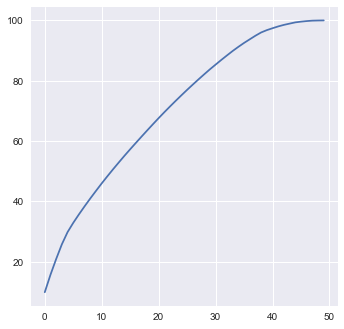

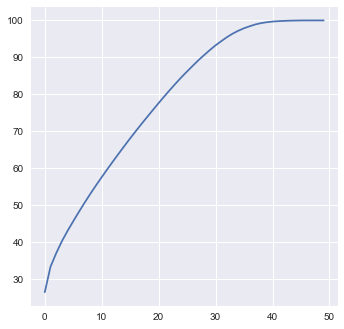

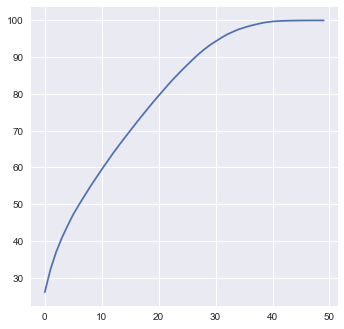

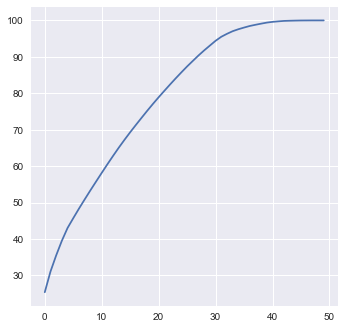

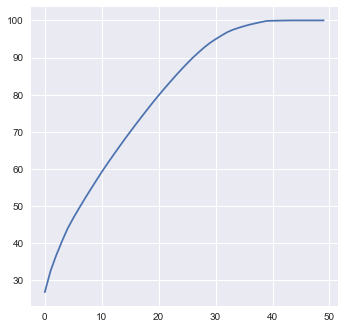

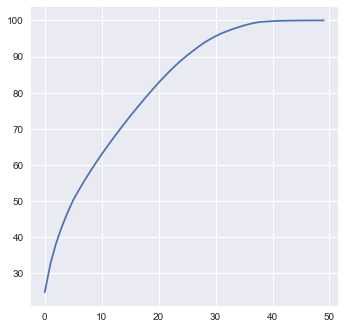

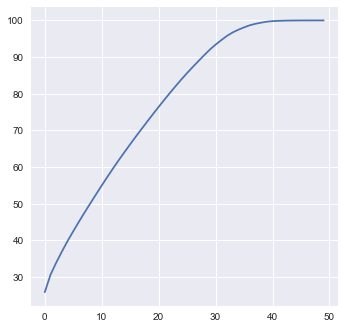

In [240]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

# Holds X for each of the 7 sectors
X_array = []
X_array.append("")
for i in range(1, 8):
    #convert it to numpy arrays
    X = X_trains[i]

    #Scaling the values
    X = scale(X)

    pca = PCA(n_components=50)

    pca.fit(X)

    #The amount of variance that each PC explains
    var= pca.explained_variance_ratio_

    #Cumulative Variance explains
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    print (var1)
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(var1)

    

In [241]:
from sklearn.preprocessing import StandardScaler
PCA_choice = {1: 25, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30} # Based on Graphs
for i in range(1, 8):
    pca = PCA(n_components=PCA_choice[i])
    scaler = StandardScaler()
    X_trains[i] = scaler.fit_transform(X_trains[i])
    X_tests[i] = scaler.transform(X_tests[i])
    X_trains[i] = pca.fit_transform(X_trains[i])
    X_tests[i] = pca.transform(X_tests[i])

In [250]:
from sklearn.metrics import mean_squared_error
from math import sqrt



print("y_test_mean = ", y_test_mean)

baseline_average_rmses = [""]

for i in range(1, 8):
    y_test_mean = y_tests[i].mean()
    y_prediction = np.zeros(len(y_tests[i]))
    y_prediction.fill(y_trains[i].mean())

    rmse = sqrt(mean_squared_error(y_tests[i], y_prediction))
    print("Model {}'s baseline average rmse is {}, which is {:.2%} off (y_mean is {})".format(i, rmse, rmse/y_test_mean, y_test_mean))
    baseline_average_rmses.append(rmse)
    
    
print()

baseline_persistence_rmses = [""]

for i in range(1, 8):
    y_test_mean = y_tests[i].mean()
    y_prediction = np.concatenate(([y_trains[i][-1]], y_tests[i][:-1]))

    rmse = sqrt(mean_squared_error(y_tests[i], y_prediction))
    print("Model {}'s baseline persistence rmse is {}, which is {:.2%} off (y_mean is {})".format(i, rmse, rmse/y_test_mean, y_test_mean))
    baseline_average_rmses.append(rmse)    


y_test_mean =  3.44072948328
Model 1's baseline average rmse is 3.8944124828718425, which is 38.24% off (y_mean is 10.185410334346505)
Model 2's baseline average rmse is 4.920616622155097, which is 30.84% off (y_mean is 15.954407294832826)
Model 3's baseline average rmse is 4.7973041334904, which is 25.31% off (y_mean is 18.951367781155014)
Model 4's baseline average rmse is 3.5920945313114987, which is 33.83% off (y_mean is 10.617021276595745)
Model 5's baseline average rmse is 3.953634949271786, which is 30.80% off (y_mean is 12.835866261398177)
Model 6's baseline average rmse is 4.298484651870332, which is 34.39% off (y_mean is 12.498480243161094)
Model 7's baseline average rmse is 1.785595553777242, which is 51.90% off (y_mean is 3.440729483282675)

Model 1's baseline persistence rmse is 4.705296763136129, which is 46.20% off (y_mean is 10.185410334346505)
Model 2's baseline persistence rmse is 6.185334159333187, which is 38.77% off (y_mean is 15.954407294832826)
Model 3's baseline

In [43]:
print(X_trains[i].shape)
print(y_trains[i].shape)
print(X_tests[i].shape)
print(y_tests[i].shape)

(1314, 30)
(1314,)
(328, 30)
(328,)


/Users/cheryljose/Documents/Projects/TestProject/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


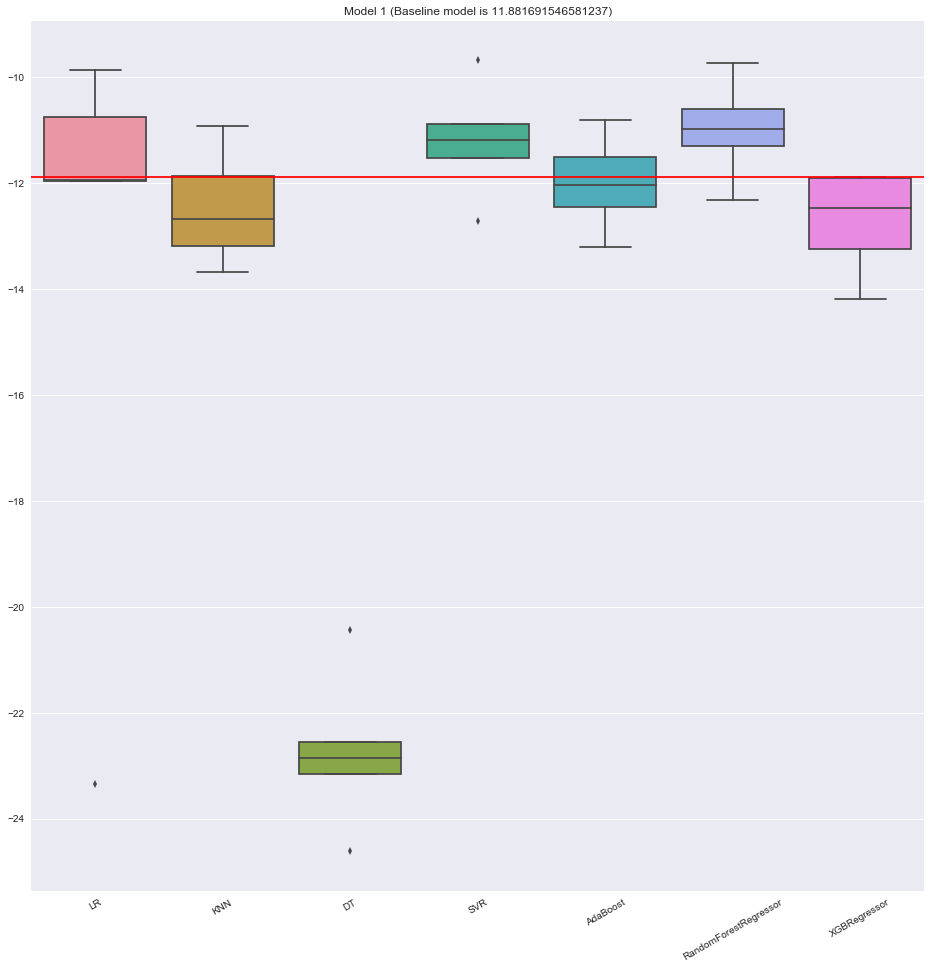

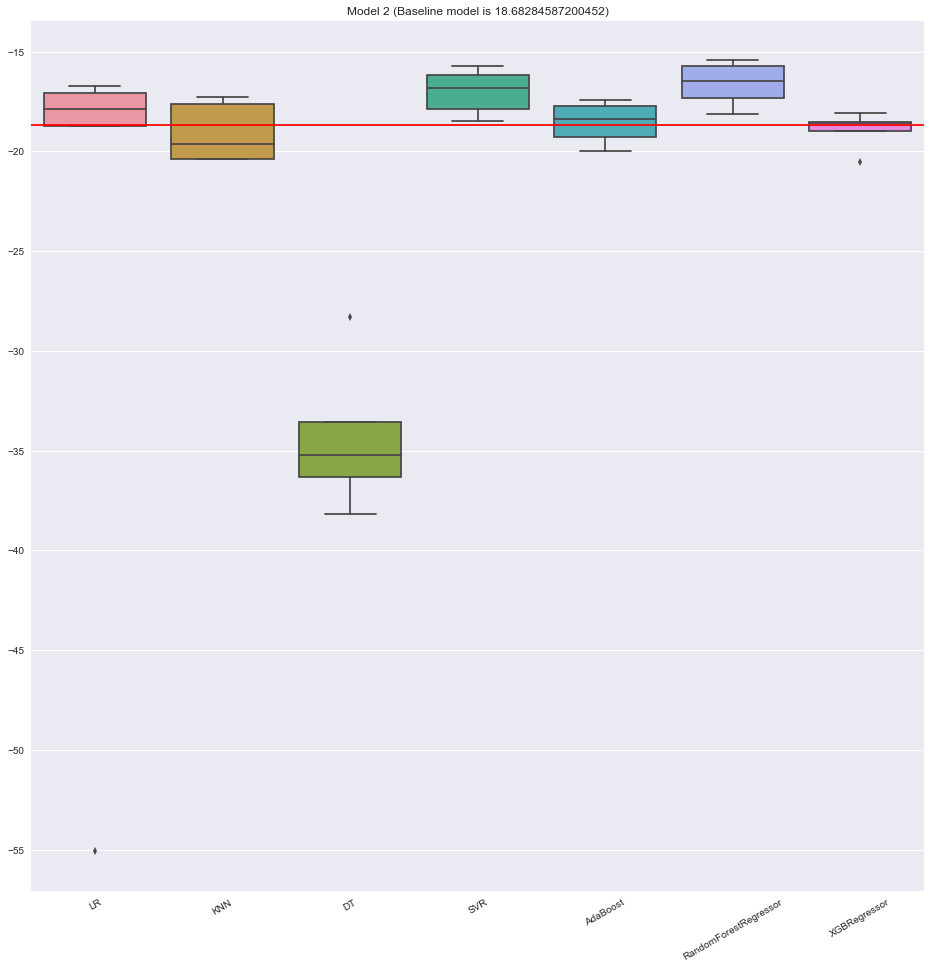

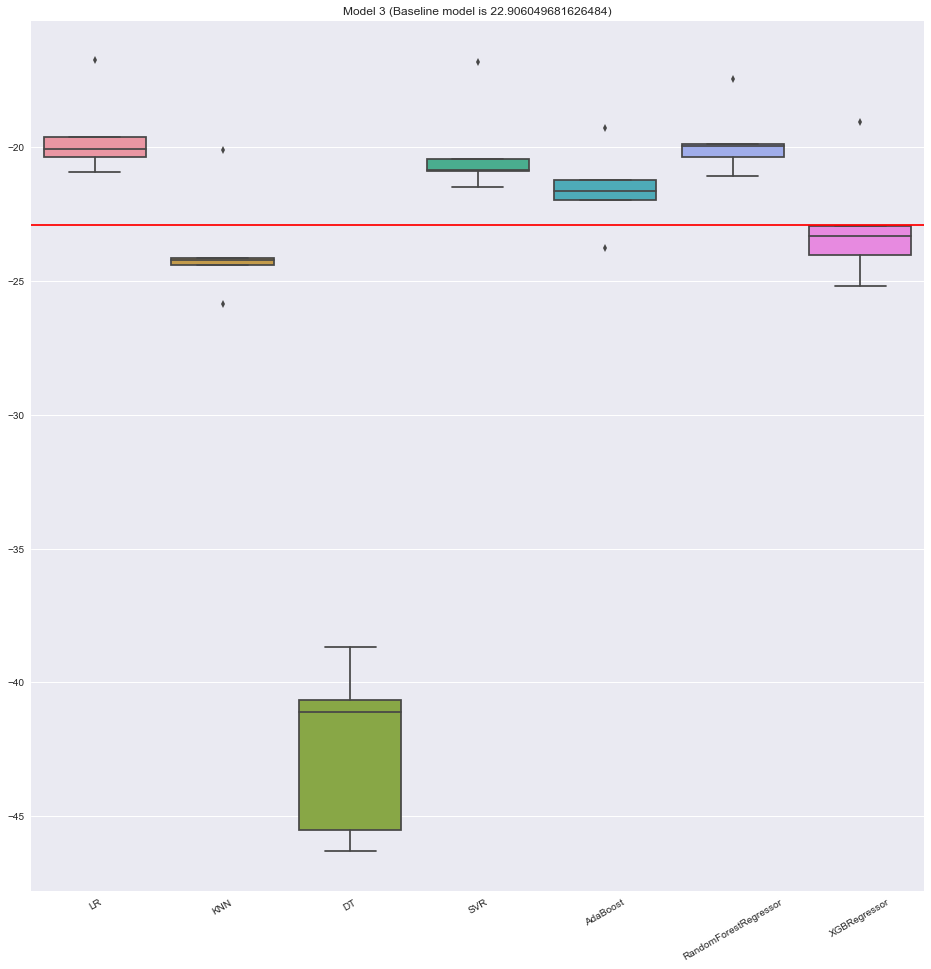

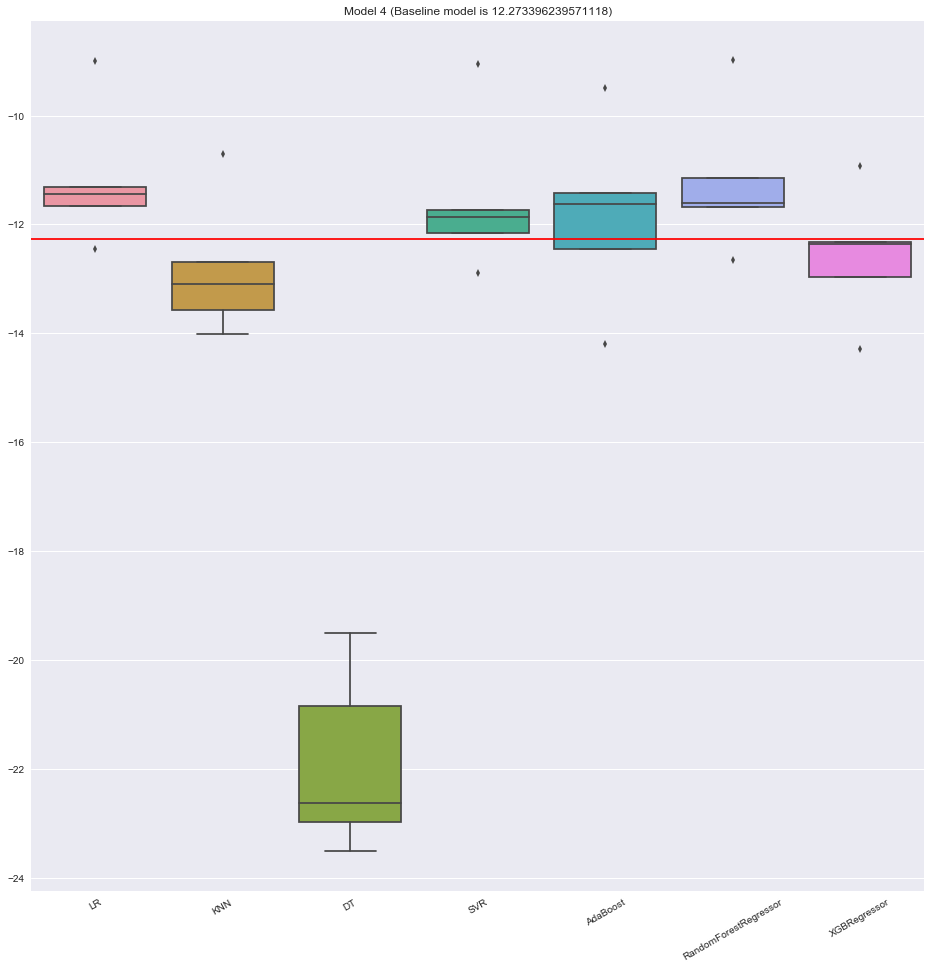

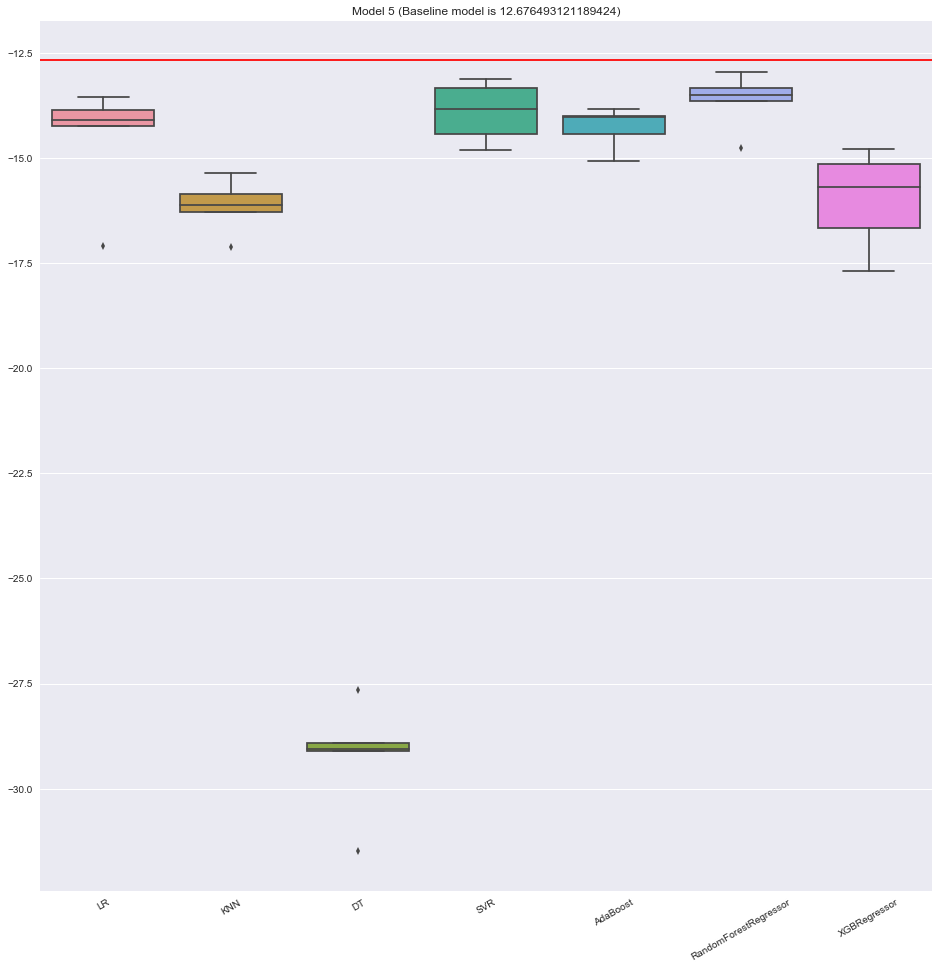

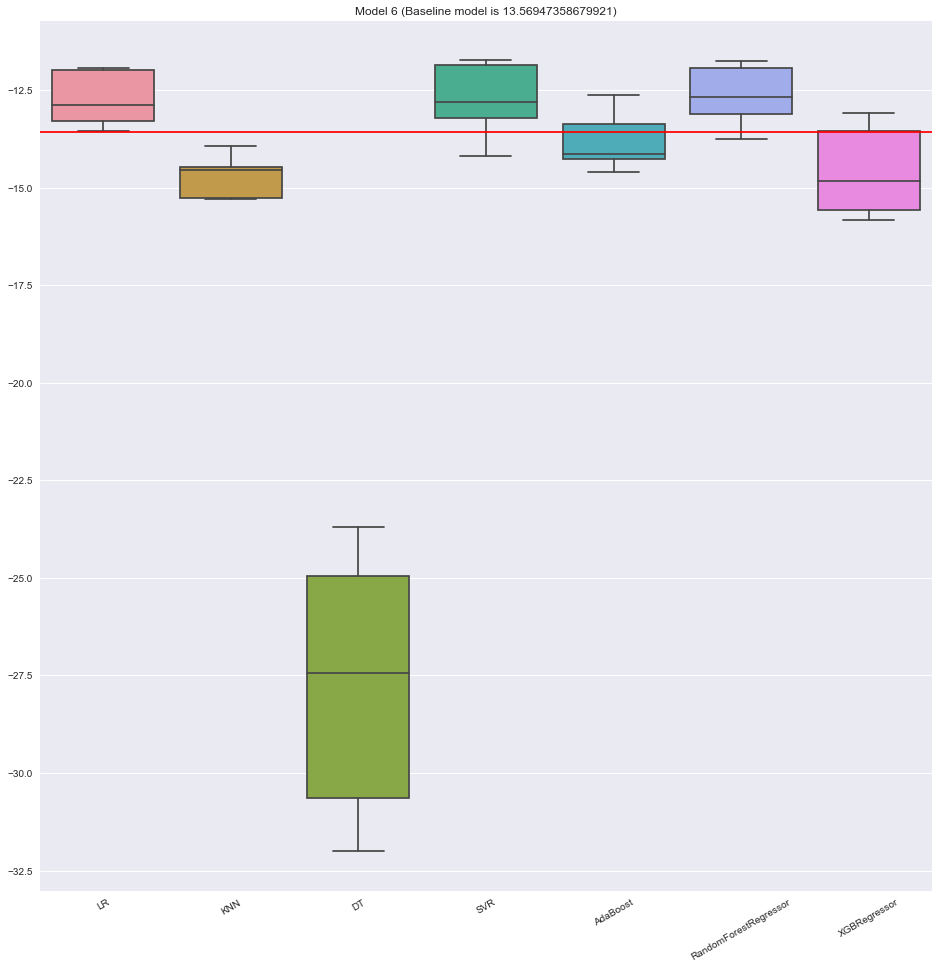

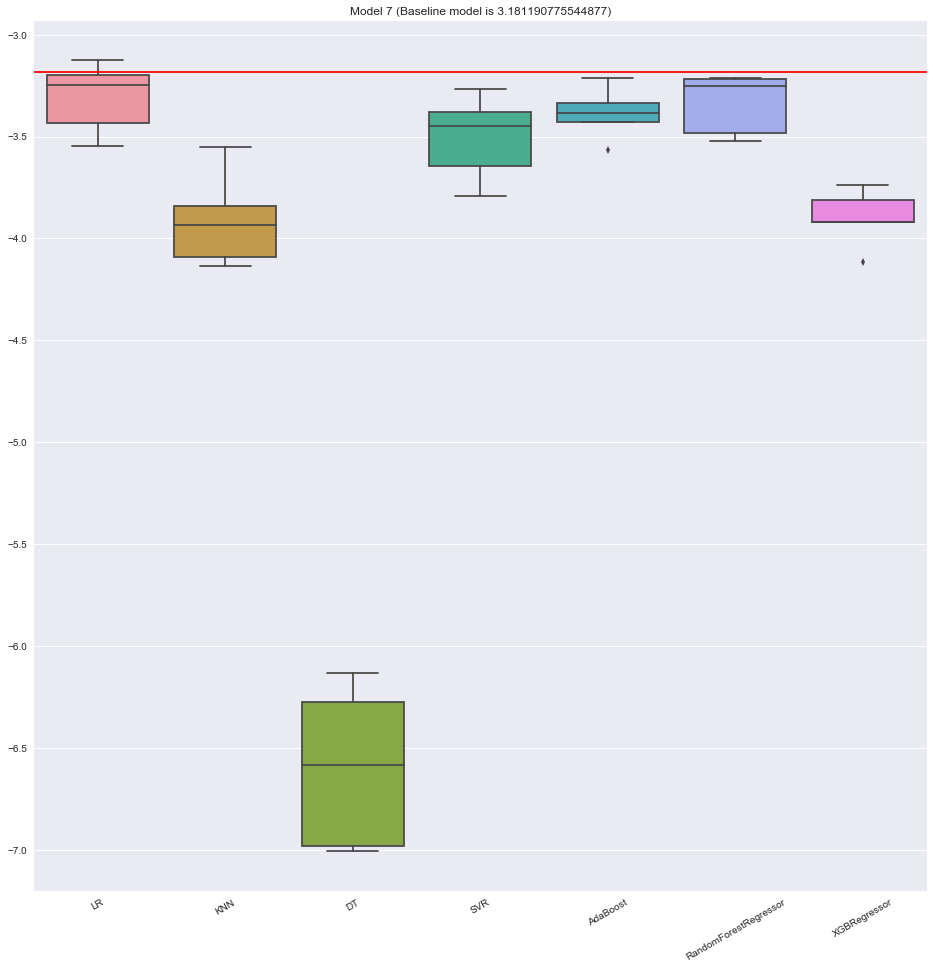

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

for i in range(1, 8):
    models = []
    models.append(("LR",LinearRegression()))
    models.append(("KNN",KNeighborsRegressor()))
    models.append(("DT",DecisionTreeRegressor()))
    models.append(("SVR",SVR()))
    models.append(("AdaBoost",AdaBoostRegressor(n_estimators=500, random_state=2)))
    models.append(("RandomForestRegressor",RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
                                            bootstrap = True,random_state=2)))
    models.append(("XGBRegressor",make_pipeline(
        StackingEstimator(estimator=RidgeCV()),
        XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
    )))

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=5, random_state=22)
        cv_result = cross_val_score(model, X_trains[i], y_trains[i], cv = kfold, scoring='neg_mean_squared_error')
        names.append(name)
        results.append(cv_result)
        
#     for i in range(len(names)):
#         print(names[i], results[i].mean())
        
    fig, ax = plt.subplots(figsize=(16, 16))
    ax = sns.boxplot(data=results)
    ax.set_xticklabels(names, rotation=30)
    plt.title("Model {} (Baseline model is {})".format(i, baseline_mses[i]))
    plt.plot(np.linspace(-20,120,1000), [-1*baseline_mses[i]]*1000, 'r')
    plt.savefig('images/Model_{}_Results_new.png'.format(i))
    
    
    

### Genetic Algorithm

In [45]:
# for i in range(1, 8):
#     tpot = TPOTRegressor(verbosity=2, max_time_mins=20)
#     tpot.fit(X_trains[i], y_trains[i]) 
#     print(tpot.score(X_tests[i], y_tests[i]))
#     tpot.export('tpot_pipeline_model_{}.py'.format(i))

## TODO

- Do feature importance

## Build the Final Models

##### Sector 1 - SVR

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_svr = Pipeline([('clf', SVR())])
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
epsilon_range = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
param_grid = [{'clf__C': param_range,
               'clf__epsilon': epsilon_range,
              'clf__kernel': ['linear']
              },
              {'clf__C': param_range,
               'clf__epsilon': epsilon_range,               
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']
              }
             ]
gs = GridSearchCV(estimator=pipe_svr,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[1], y_trains[1])
print(gs.best_score_)
print(gs.best_params_)
                  

/Users/cheryljose/Documents/Projects/TestProject/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/cheryljose/Documents/Projects/TestProject/venv/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


-10.952928153231303
{'clf__C': 20.0, 'clf__epsilon': 1.0, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}


In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model1 = SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf')
final_model1.fit(X_trains[1],y_trains[1],sample_weight=None)
y_predict = final_model1.predict(X_tests[1])
root_mse = sqrt(mean_squared_error(y_tests[1], y_predict))
print(root_mse)

3.4390398505233297


In [48]:
list(X_train)

['is_monday',
 'is_tuesday',
 'is_thursday',
 'is_friday',
 'is_saturday',
 'is_sunday',
 'collisions',
 'is_12PM_3PM',
 'is_3PM_6PM',
 'is_9PM_12AM',
 'avg_density_per_collision',
 'avg_wealth_per_collision',
 'avg_no_u_turn_signs_per_collision',
 'low_severity',
 'number_killed',
 'number_injured',
 'count_bicyclist_injured',
 'intersection_N',
 'intersection_Y',
 'weather_1_A',
 'weather_1_C',
 'location_type_H',
 'location_type_N',
 'location_type_R',
 'primary_coll_factor_A',
 'pcf_viol_category_01',
 'pcf_viol_category_03',
 'pcf_viol_category_05',
 'pcf_viol_category_06',
 'pcf_viol_category_07',
 'pcf_viol_category_08',
 'pcf_viol_category_13',
 'pcf_viol_category_18',
 'pcf_viol_category_22',
 'hit_and_run_M',
 'hit_and_run_N',
 'type_of_collision_A',
 'type_of_collision_B',
 'type_of_collision_C',
 'type_of_collision_E',
 'type_of_collision_F',
 'road_surface_A',
 'road_surface_B',
 'road_cond_1_B',
 'road_cond_1_C',
 'road_cond_1_H',
 'lighting_A',
 'lighting_C',
 'control_d

##### Sector 2 - Random Forest

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[2], y_trains[2])
print(gs.best_score_)
print(gs.best_params_)
                  

-16.32360046009578
{'clf__criterion': 'mse', 'clf__max_features': 'auto', 'clf__min_samples_leaf': 140, 'clf__n_estimators': 300}


In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model2 = RandomForestRegressor(max_features='auto', min_samples_leaf=100, n_estimators = 100)
final_model2.fit(X_trains[2],y_trains[2],sample_weight=None)
y_predict = final_model2.predict(X_tests[2])
rmse = sqrt(mean_squared_error(y_tests[2], y_predict))
print(rmse)

4.300885476848823


##### Sector 3 - RandomForest

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[3], y_trains[3])
print(gs.best_score_)
print(gs.best_params_)
                  

-19.681430422533577
{'clf__criterion': 'mse', 'clf__max_features': 0.2, 'clf__min_samples_leaf': 60, 'clf__n_estimators': 300}


In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model3 = RandomForestRegressor(max_features='sqrt', min_samples_leaf=60, n_estimators = 300)
final_model3.fit(X_trains[3],y_trains[3],sample_weight=None)
y_predict = final_model3.predict(X_tests[3])
rmse = sqrt(mean_squared_error(y_tests[3], y_predict))
print(1*mse)

3.18119077554


##### Sector 4 - RandomForest

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[4], y_trains[4])
print(gs.best_score_)
print(gs.best_params_)
                  

-11.215167089925863
{'clf__criterion': 'mse', 'clf__max_features': 'auto', 'clf__min_samples_leaf': 60, 'clf__n_estimators': 100}


In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model4 = RandomForestRegressor(max_features=0.2, min_samples_leaf=60, n_estimators = 700)
final_model4.fit(X_trains[4],y_trains[4],sample_weight=None)
y_predict = final_model4.predict(X_tests[4])
rmse = sqrt(mean_squared_error(y_tests[4], y_predict))
print(1*rmse)

3.3738947599686093


##### Sector 5 - LassoLarsCV

In [55]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file

# Score on the training set was:-13.691069703936401
exported_pipeline = make_pipeline(
    SelectFwe(score_func=f_regression, alpha=0.009000000000000001),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.65, tol=0.0001)),
    LassoLarsCV(normalize=True)
)

exported_pipeline.fit(X_trains[5], y_trains[5])
y_predict = exported_pipeline.predict(X_tests[5])
rmse = sqrt(mean_squared_error(y_tests[5], y_predict))
print(1*rmse)

3.511463142294711


##### Sector 6 - SVR

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_svr = Pipeline([('clf', SVR())])
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
epsilon_range = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
param_grid = [{'clf__C': param_range,
               'clf__epsilon': epsilon_range,
              'clf__kernel': ['linear']
              },
              {'clf__C': param_range,
               'clf__epsilon': epsilon_range,               
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']
              }
             ]
gs = GridSearchCV(estimator=pipe_svr,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[6], y_trains[6])
print(gs.best_score_)
print(gs.best_params_)
                  

-12.468483812462596
{'clf__C': 0.5, 'clf__epsilon': 0.1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model6 = SVR(C=0.5, epsilon=1.0, gamma=0.01, kernel = 'rbf')
final_model6.fit(X_trains[6],y_trains[6],sample_weight=None)
y_predict = final_model6.predict(X_tests[6])
rmse = sqrt(mean_squared_error(y_tests[6], y_predict))
print(rmse)

3.561123657562194


##### Sector 7 - RandomForest

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[7], y_trains[7])
print(gs.best_score_)
print(gs.best_params_)
                  

-3.25167920768544
{'clf__criterion': 'mse', 'clf__max_features': 0.2, 'clf__min_samples_leaf': 100, 'clf__n_estimators': 100}


In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt
final_model7 = RandomForestRegressor(max_features='log2', min_samples_leaf=60, n_estimators = 300)
final_model7.fit(X_trains[7],y_trains[7],sample_weight=None)
y_predict = final_model7.predict(X_tests[7])
rmse = sqrt(mean_squared_error(y_tests[7], y_predict))
print(1*rmse)

1.780177301650373


In [60]:
my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
                                        bootstrap = True,random_state=2)

#train the RandomForest alg by using the FIT method

X_train, X_test, y_train, y_test = train_test_split(df2.drop("accidents",axis=1),
                                                    df2['accidents'],
                                                    train_size=0.75, test_size=0.25)


my_RandomForest.fit(X_train,y_train,sample_weight=None)

#Make prediction over the trained RandomForest alg using the testing sample:

y_predict = my_RandomForest.predict(X_test)

# from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split



# print(y_predict)

# Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# portion of correct predictions:
from sklearn.metrics import mean_squared_error
mse_RF = mean_squared_error(y_test, y_predict)
print(mse_RF)

NameError: name 'df2' is not defined

# Feature Importance

### Model 1

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[1], y_trains[1])
print(gs.best_score_)
print(gs.best_params_)
                  


In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features='auto', min_samples_leaf=60, n_estimators = 100)
feature_importance_model1.fit(X_trains[1],y_trains[1],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[1])
mse = mean_squared_error(y_tests[1], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[1].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_1_feature_importance.png')

### Model 2

In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features='auto', min_samples_leaf=100, n_estimators = 100)
feature_importance_model1.fit(X_trains[2],y_trains[2],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[2])
mse = mean_squared_error(y_tests[2], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[2].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_2_feature_importance.png')

### Model 3

In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features='sqrt', min_samples_leaf=60, n_estimators = 300)
feature_importance_model1.fit(X_trains[3],y_trains[3],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[3])
mse = mean_squared_error(y_tests[3], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[3].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_3_feature_importance.png')

### Model 4

In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features=0.2, min_samples_leaf=60, n_estimators = 700)
feature_importance_model1.fit(X_trains[4],y_trains[1],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[1])
mse = mean_squared_error(y_tests[4], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[4].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_4_feature_importance.png')

### Model 5

- Random forest didn't beat baseline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[5], y_trains[5])
print(gs.best_score_)
print(gs.best_params_)
                  


In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features='sqrt', min_samples_leaf=60, n_estimators = 700)
feature_importance_model1.fit(X_trains[5],y_trains[5],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[5])
mse = mean_squared_error(y_tests[5], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[5].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_5_feature_importance.png')

### Model 6

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[6], y_trains[6])
print(gs.best_score_)
print(gs.best_params_)
                  


In [ ]:

from sklearn.metrics import mean_squared_error
feature_importance_model1 = RandomForestRegressor(max_features='auto', min_samples_leaf=60, n_estimators = 300)
feature_importance_model1.fit(X_trains[5],y_trains[5],sample_weight=None)
y_predict = feature_importance_model1.predict(X_tests[5])
mse = mean_squared_error(y_tests[5], y_predict)
print(-1*mse)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_trains[5].columns, feature_importance_model1.feature_importances_):
    #print(feature, importance)
    feats[feature] = importance #add the name/value pair 


    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
importances = importances.query('gini_importance>=0.04')
importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.savefig('images/Model_6_feature_importance.png')

### Model 7

- Random forest didn't beat baseline

In [ ]:



# from sklearn.metrics import mean_squared_error
# feature_importance_model1 = RandomForestRegressor(max_features='log2', min_samples_leaf=60, n_estimators = 300)
# feature_importance_model1.fit(X_trains[7],y_trains[7],sample_weight=None)
# y_predict = feature_importance_model1.predict(X_tests[7])
# mse = mean_squared_error(y_tests[7], y_predict)
# print(-1*mse)

# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(X_trains[7].columns, feature_importance_model1.feature_importances_):
#     #print(feature, importance)
#     feats[feature] = importance #add the name/value pair 


    
# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
# importances = importances.query('gini_importance>=0.04')
# importances.sort_values(by='gini_importance').plot(kind='bar', rot=90)
# plt.savefig('images/Model_7_feature_importance.png')

### If you need a new model for a sector
tpot = TPOTRegressor(verbosity=2, generations=5)

tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

tpot.export('tpot_pipeline.py')


# Old Code and Notes

### Decide Which Models will be used

- Random Forest
- Linear Regression
- Decision tree
- KNN
- SVR
- Adaboost
- Baseline
- GradientBoostingRegressor 
- GaussianProcessRegressor
- LinearSVR
- Ridge Regression
- Lasso
- try XGBoost, ann and deep learning


### Decide Which Hyperparameters to Tune for Each Model

- Use Grid search
- Random Forest (max_features: auto, sqrt, log2, 0.2 / n_estimators: 100, 300, 700 / min_sample_leaf: 60, 100, 140, 180, criterion: ?)
- Linear Regression (learning rate, not sure ?)
- Decision tree(max_depth; deeper the tree, more info about the data, min_samples_split, min_smaples-leaf, max_features)
- KNN(n_neighbors, p in L-p distance)
- SVR(C (GridSearch), epsilon, and, assuming you use an RBF kernel function, gamma)
- Adaboost (Learning Rate(try 0.01 during modelling and set it very small 0.0001 later), maximum_no._of_splits, no. of weak learners should be high)
- Baseline(N/A)
- GradientBoostingRegressor (learning_rate, n_estimators, max_depth,min_samples_split,min_samples_leaf,max_features)
- GaussianProcessRegressor (learning_rate, regularization,Kernel)
- LinearSVR(open tab)
- Ridge Regression
- alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
- Lasso
- alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

### Do Feature selection, anything allowed

- Best [100, 75, 50, 25, 12] variables used
- Only choose the features once
- Run this cell and those below when you decide to change the # of features to use

In [ ]:

# # NOTE: Make sure that the class is labeled 'target' in the data file
# #tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# #features = tpot_data.drop('target', axis=1).values
# #training_features, testing_features, training_target, testing_target = \
#            # train_test_split(features, tpot_data['target'].values, random_state=42)

# # Score on the training set was:-0.13621358017694313
# exported_pipeline = make_pipeline(
#     StackingEstimator(estimator=RidgeCV()),
#     XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
# )

# exported_pipeline.fit( X_train,y_train)
# results = exported_pipeline.predict(X_test)
# df = pd.DataFrame()
# df['y_test'] = y_test
# df['results'] = results
# df.to_csv('test_result.csv')

# from sklearn.ensemble import RandomForestRegressor

# my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
#                                         bootstrap = True,random_state=2)

# #train the RandomForest alg by using the FIT method

# my_RandomForest.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained RandomForest alg using the testing sample:

# y_predict = my_RandomForest.predict(X_test)

# # print(y_predict)


# # Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# # portion of correct predictions:
# from sklearn.metrics import mean_squared_error
# mse_RF = mean_squared_error(y_test, y_predict)
# print(mse_RF)

# from sklearn.neural_network import MLPRegressor

# my_ANN = MLPRegressor(hidden_layer_sizes=(6,4), activation= 'logistic', 
#                        solver='lbfgs', alpha=1e-5, random_state=1 )


# # Training ONLY on the training set:
# my_ANN.fit(X_transform, y_train)

# # Weights:
# print(my_ANN.coefs_)
# # The ith element in the list represents the weight matrix corresponding to layer i.

# print('\n')

# # Bias weights:
# print(my_ANN.intercepts_)
# # The ith element in the list represents the bias vector corresponding to layer i + 1.

# # Testing on the testing set:
# y_predict_ann = my_ANN.predict(X_transform_test)
# print(y_predict_ann)

# # We can now compare the "predicted labels" for the Testing Set with its "actual labels" to evaluate the accuracy 

# mse_ann = mean_squared_error(y_test, y_predict_ann)
# print(mse_ann)




# # Adaboost (Learning Rate(try 0.01 during modelling and set it very small 0.0001 later), maximum_no._of_splits, no. of weak learners should be high)
# # Baseline(N/A)

# # Adaboost is a classifier which gives weightage to each features and reduces the errors in getting the best prediction

# from sklearn.ensemble import AdaBoostRegressor

# my_AdaBoost = AdaBoostRegressor(n_estimators=500, random_state=2)

# #train the adaboost alg by using the FIT method

# my_AdaBoost.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained Adaboost alg using the testing sample:

# y_adaboost_predict = my_AdaBoost.predict(X_test)

# # print(y_adaboost_predict)
# print(y_adaboost_predict.shape)

# adaboost_mse = mean_squared_error(y_test, y_adaboost_predict)

# print(adaboost_mse)


# # Best pipeline: XGBRegressor(RidgeCV(input_matrix), learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
# # -0.114416034755
# -0.114416034755

# # Best so Far
# - 10.89: 240, log2, 5 (using 100 best features and no PCA)
# - .732: 1000, log2, 5 (20 features and 8 PCA)

# from sklearn.ensemble import RandomForestRegressor

# my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
#                                         bootstrap = True,random_state=2)

# #train the RandomForest alg by using the FIT method

# my_RandomForest.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained RandomForest alg using the testing sample:

# y_predict = my_RandomForest.predict(X_test)

# # print(y_predict)


# # Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# # portion of correct predictions:
# from sklearn.metrics import mean_squared_error
# mse_RF = mean_squared_error(y_test, y_predict)
# print(mse_RF)

# from sklearn.linear_model import LinearRegression
# # In the following line, "my_linreg" is instantiated as an "object" of LinearRegression "class". 

# my_linreg = LinearRegression()

# # fitting the model to the training data:
# my_linreg.fit(X_train, y_train)

# # printing Theta0 using attribute "intercept_":
# #print(my_linreg.intercept_)

# # printing [Theta1, Theta2, Theta3, Theta4, Theta5, Theta6, Theta7] using attribute "coef_":
# #print(my_linreg.coef_)

#  # make predictions on the testing set
# y_prediction = my_linreg.predict(X_test)

# # print(y_prediction)

# from sklearn import metrics
# import numpy as np

# # Calculating "Mean Square Error" (MSE):
# mse = metrics.mean_squared_error(y_test, y_prediction)

# # Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
# rmse = np.sqrt(mse)

# print("mse is ", mse)



# mse_RF = mean_squared_error(y_train, my_RandomForest.predict(X_train))
# print(mse_RF)


# my_RandomForest.score(X_test,y_test)

# my_RandomForest



### Lime

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVR
# #     sector1_df = sector1_df_backup
# selected_best_features = []
# selected_best_features.append("")

# X = train.drop(["collisions_tomorrow"], axis=1)
# y = train['collisions_tomorrow']

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# select_top_50 = SelectKBest(score_func=f_regression, k = 50)
# fit = select_top_50.fit(X,y)
# features = fit.transform(X)
# mask = select_top_50.get_support()
# selected_best_features = X.columns[mask]

# from pandas import DataFrame
# from typing import Set, Any
# def remove_others(df: DataFrame, columns: Set[Any]):
#     cols_total: Set[Any] = set(df.columns)
#     diff: Set[Any] = cols_total - columns
#     df.drop(diff, axis=1, inplace=True)
# remove_others(X, set(selected_best_features))
# selected_best_features

# PCA_choice = {1: 25, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30} # Based on Graphs
# pca = PCA(n_components=PCA_choice[1])
# pipe = Pipeline([('scl', StandardScaler()),                     
#                      ('clf', SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf'))
#                 ])

# pipe.fit(X, y)
# y_predict = pipe.predict(X)
# mse = mean_squared_error(y, y_predict)
# print(-1*mse)

# predict_pipeline = lambda x: pipe.predict(x).astype(float)







# import lime
# import lime.lime_tabular
# explainer = lime.lime_tabular.LimeTabularExplainer(X.values, \
#                                                    feature_names=X.columns, \
#                                                    class_names=['tomorrow_collisions'], \
#                                                    categorical_features=None, \
#                                                    verbose=True, \
#                                                    mode='regression')

# i = 13
# exp = explainer.explain_instance(y.values, pipe.predict, num_features=50)

# exp.show_in_notebook(show_table=True)
# exp.as_list()

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVR
# lime_X_train = train.drop(["collisions_tomorrow"], axis=1)
# lime_y_train = train['collisions_tomorrow']
# lime_X_test = test.drop(["collisions_tomorrow"], axis=1)
# lime_y_test = test['collisions_tomorrow']

# pipe = Pipeline([('scl', StandardScaler()),                     
#                  ('clf', SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf'))
#                 ])
# pipe.fit(lime_X_train, lime_y_train)
# y_predict = pipe.predict(lime_X_test)
# mse = mean_squared_error(lime_y_test, y_predict)
# print(-1*mse)

# # predict_pipeline = lambda x: pipe.predict(x).astype(float)

# import lime
# import lime.lime_tabular
# explainer = lime.lime_tabular.LimeTabularExplainer(X.values, \
#                                                    feature_names=X.columns, \
#                                                    class_names=['tomorrow_collisions'], \
#                                                    categorical_features=None, \
#                                                    verbose=True, \
#                                                    mode='regression')

# i = 13
# exp = explainer.explain_instance(lime_X_test.values[2], pipe.predict, num_features=50)

# # exp.show_in_notebook(show_table=True)
# # exp.as_list()

In [ ]:
#     sector1_df = sector1_df_backup
selected_best_features = []
selected_best_features.append("")

X = train.drop(["collisions_tomorrow"], axis=1)
y = train['collisions_tomorrow']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_top_20 = SelectKBest(score_func=chi2, k = 50)
fit = select_top_20.fit(X,y)
features = fit.transform(X)
mask = select_top_20.get_support()
selected_best_features = X.columns[mask]

from pandas import DataFrame
from typing import Set, Any
def remove_others(df: DataFrame, columns: Set[Any]):
    cols_total: Set[Any] = set(df.columns)
    diff: Set[Any] = cols_total - columns
    df.drop(diff, axis=1, inplace=True)
remove_others(X, set(selected_best_features))
selected_best_features

pipe = Pipeline([('scl', StandardScaler()),      
                     ('clf', SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf'))
                ])

pipe.fit(X, y)
y_predict = pipe.predict(X)
mse = mean_squared_error(y, y_predict)
print(-1*mse)

predict_pipeline = lambda x: pipe.predict(x).astype(float)







import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_trains[1].values, \
                                                   feature_names=X_trains[1].columns, \
                                                   class_names=['tomorrow_collisions'], \
                                                   categorical_features=None, \
                                                   verbose=True, \
                                                   mode='regression')

i = 13
exp = explainer.explain_instance(X_tests[1].values[i], pipe.predict, num_features=50)

exp.show_in_notebook(show_table=True)